# Project 1
**Maddy Bursell, Kim McKeever**

In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns

## Part 1: Data Processing

### Read in the data

In this project, we will be reading in files that use 2010 US census data. The goal will be to first read in the data and parse it into a format we can use. We will do this using a series of functions for data processing, combining data, and doing cross-validation.  

First, we read in the initial census data to examine:

In [3]:
import_data = pd.read_csv("https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv")
import_data.head()

,Area_name,STCOU,EDU010187F,EDU010187D,EDU010187N1,EDU010187N2,EDU010188F,EDU010188D,EDU010188N1,EDU010188N2,...,EDU010194N1,EDU010194N2,EDU010195F,EDU010195D,EDU010195N1,EDU010195N2,EDU010196F,EDU010196D,EDU010196N1,EDU010196N2
0,UNITED STATES,0,0,40024299,0,0,0,39967624,0,0,...,0,0,0,43993459,0,0,0,44715737,0,0
1,ALABAMA,1000,0,733735,0,0,0,728234,0,0,...,0,0,0,727989,0,0,0,736825,0,0
2,"Autauga, AL",1001,0,6829,0,0,0,6900,0,0,...,0,0,0,7568,0,0,0,7834,0,0
3,"Baldwin, AL",1003,0,16417,0,0,0,16465,0,0,...,0,0,0,19961,0,0,0,20699,0,0
4,"Barbour, AL",1005,0,5071,0,0,0,5098,0,0,...,0,0,0,5017,0,0,0,5053,0,0


We can see that the data contains many columns and many different kinds of variables within columns. It will be helpful to clean up the data to be more understandable before we begin to use it.

### Create functions to clean and process the data

Functions can be extremely useful when you want to process multiple files in the same way. In this section, we will define 5 different functions that will be called in one wrapper function. All of the functions will work to select only the specific columns we want, create new columns we need, and format the data how we want it. 

In **func_1** we first want to clean up the data by selecting only certain columns and renaming one column. Our step one will be to rename the "Area_name" column as "area_name" and to grab all of the columns that end in the letter "D." To do this, it is easiest to create a function that we can use on other datasets down the line. In this function, we take in a dataframe as the input and we have an optional argument to name the new column. The default name of the new column is "enrollment." 

We only want to maintain a few columns with specific parameters: we want 'Area_name', 'STCOU', and any column that ends with the letter 'D'. Since we want to select all columns ending in "D", we are locating those names first. Creating a list of desired columns for our modified data frame by using specific coumn names from the import data and by unpacking the list of column names that end with "D" that was generated in the previous line. Next, using the `.loc()` method and the desired columns found in 'col_list', we add those columns to our dataframe. Lastly, we will convert our data into long format where each row has only one enrollment value for the column area_name. This will help to get rid of multiple observations in a given row.

In [4]:
def func_1(df_1, col_name = "enrollment"):
    
    # Change the column name
    df_2 = df_1.rename(columns = {"Area_name":"area_name"}, inplace = True)
    
    # Create a list of the column names and an empty list to grab all of the columns ending in "D"
    cols=list(df_1)
    col_names=[]
    
    # We will use a for loop to iterate through the columns and grab the column names ending in "D" into a list
    for x in cols:
        if x.endswith("D"):
            col_names.append(x)
        else:
            continue
            
    # We can subset our original dataframe to grab the columns we want with the list "col_list"
    col_list=['area_name', 'STCOU', *col_names]
    df_2=df_1.loc[:,col_list]
    
    # Convert the dataframe to long format using pd.melt()
    df_2 = df_2.melt(id_vars = ["area_name", "STCOU"], var_name = "info", value_name = col_name)
    
    return(df_2)
    

In **func_2**, we are taking the output of func_1 and processing it even more. Each variable in the info column holds important information. The last two characters before the "D" represent the year. We want to create a new column called "year" that stores the year. The first three characters represent the survey and the next four represent the type of value you have from the survey. We want to capture those first seven characters in another column called "measurement."

First, we will create new empty columns in our dataframe. Then, we will loop through the dataframe by the row, find the info column value, and parse out the measurment and the year. the value for each row will be added to the new columns of the dataframe. 

In [5]:
def func_2(df_2): 
    
    df_2["year"] = np.nan
    df_2["measurement"] = np.nan
    for row in range(len(df_2)):
        thing = df_2.loc[row, "info"]
        measure = thing[0:7]
        if int(thing[7:9])>=23:
            yr = "19" + str(thing[7:9])
        else:
            yr= '20'+ str(thing[7:9])
        df_2.loc[row,"year"] = int(yr)
        df_2.loc[row,"measurement"] = str(measure)
        
    return(df_2)

In **func_3**, we are only editing the county-level data. This function will be called within a later function (func_5) once we have split our original dataframe into two new dataframes called county_df and state_df. In func_3, we are taking the county_df and creating a new column in it where we have the state for each row. 

In [6]:
def func_3(dataframe):
    
    dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
    
    return(dataframe)

In **func_4**, we are editing only the state-level data. This function will be called in func_5, after we have created the two new dataframes called county_df and state_df. In this function, we will be creating a new column in state_df that included the division for each of the states. We do this by using a function within a function called return_div. This will check if the state is in a certain list, and return the division to the new column in the dataframe using np.vectorize(). 

In [7]:
def func_4(dataframe):
    
    def return_div(val):
        div1 = ["CONNECTICUT", 'MAINE','MASSACHUSETTS','NEW HAMPSHIRE','RHODE ISLAND','VERMONT']
        div2 = ["NEW JERSEY",'NEW YORK','PENNSYLVANIA']
        div3 = ['ILLINOIS','INDIANA','MICHIGAN','OHIO','WISCONSIN']
        div4 = ['IOWA','KANSAS','MINNESOTA','MISSOURI','NEBRASKA','NORTH DAKOTA','SOUTH DAKOTA']
        div5 = ['DELAWARE','FLORIDA','GEORGIA','MARYLAND','NORTH CAROLINA','SOUTH CAROLINA','VIRGINIA','DISTRICT OF COLUMBIA','WEST VIRGINIA']
        div6 = ['ALABAMA','KENTUCKY','MISSISSIPPI','TENNESSEE']
        div7 = ['ARKANSAS','LOUISIANA','OKLAHOMA','TEXAS']
        div8 = ['ARIZONA','COLORADO','IDAHO','NEVADA','MONTANA','NEW MEXICO','UTAH','WYOMING']
        div9 = ['ALASKA','CALIFORNIA','HAWAII','OREGON','WASHINGTON']
        val = val.upper()
    
        if val in div1:
            return("Division 1")
        elif val in div2:
            return("Division 2")
        elif val in div3:
            return("Division 3")
        elif val in div4:
            return("Division 4")
        elif val in div5:
            return("Division 5")
        elif val in div6:
            return("Division 6")
        elif val in div7:
            return("Division 7")
        elif val in div8:
            return("Division 8")
        elif val in div9:
            return("Division 9")
        else:
            return("ERROR")
        
    dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])
    return(dataframe)
    
    

In **func_5**, we are processing the output from func_2 and creating two new dataframes. We can see that the "area_name" column holds two different kinds of values: states and counties of states. We would like to create two separate dataframes that hold the state-level data and the county-level data. To do that, we will create an indexing vector using a lambda function. The lambda function is searching the string within each row, in the 'area_name' column, searching to match if the fourth character of from the end is a `','`. This information is passed into a new column on the data frame that expresses a boolean to identify whether or not the row represented is part of a county or not. 

Now that there is a new column on `census_df` to index whether or not an area represents a county or not, the two different dataframes are created. The county data frame is generated using `.loc()` and the state dataframe is generated by running `np.logical_not()` method from numpy

The State information was then pulled from the `area_name` column to be held in its own unique column called "State"

Once we have the two new dataframes, we will call **func_3** on county_df which will add a column called "state" specifying the state in each row. We will also call **func_4** on state_df which will add a new column in that dataframe that specifies the division of each state. 

In [8]:
def func_5(dataframe):
    
    dataframe["is_county"] = dataframe["area_name"].apply(lambda x: x[-4] == ",")
    county_df = dataframe.loc[dataframe["is_county"]]
    state_df = dataframe.loc[np.logical_not(dataframe["is_county"])]
    
    county_df = func_3(county_df)
    final_county_df = county_df[["area_name", "STCOU", "enrollment", "year", "measurement", "State"]]
    state_df = func_4(state_df)
    final_state_df = state_df[["area_name", "STCOU", "enrollment", "year", "measurement", "division"]]
    
    return(final_county_df, final_state_df)

### Create a wrapper function that will call all of our previously defined functions

If we have several functions that function continuously, meaning the output of one function becomes the input of the next function, we can easily run all of these functions at once by putting them within another function. This saves time and energy, and keeps you from making mistakes while typing in the input for each individual function. In our wrapper function, we give the argument for the data to read in and then all of the functions will run, leaving us with our desired output. Because the wrapper function does most of the data processing steps, we have named it "data_processing."

In [9]:
def data_processing(URL, col_name = "enrollment"):
    
    import_data = pd.read_csv(URL)
    census_df = func_1(import_data)
    census_df_2 = func_2(census_df)
    county_df, state_df = func_5(census_df_2)
    
    return([county_df, state_df])

In [10]:
file_1 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv")
file_1

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001        6829  1987.0     EDU0101    AL
 3         Baldwin, AL   1003       16417  1987.0     EDU0101    AL
 4         Barbour, AL   1005        5071  1987.0     EDU0101    AL
 5            Bibb, AL   1007        3557  1987.0     EDU0101    AL
 6          Blount, AL   1009        7319  1987.0     EDU0101    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037        9599  1996.0     EDU0101    WY
 31976       Teton, WY  56039        2226  1996.0     EDU0101    WY
 31977       Uinta, WY  56041        5750  1996.0     EDU0101    WY
 31978    Washakie, WY  56043        1900  1996.0     EDU0101    WY
 31979      Weston, WY  56045        1479  1996.0     EDU0101    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0    40024299  1987.0     EDU0101       ERROR
 1       

In [11]:
file_2 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/EDU01b.csv")
file_2

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001        8099  1997.0     EDU0101    AL
 3         Baldwin, AL   1003       21410  1997.0     EDU0101    AL
 4         Barbour, AL   1005        5100  1997.0     EDU0101    AL
 5            Bibb, AL   1007        3717  1997.0     EDU0101    AL
 6          Blount, AL   1009        7816  1997.0     EDU0101    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037        6964  2006.0     EDU0152    WY
 31976       Teton, WY  56039        2264  2006.0     EDU0152    WY
 31977       Uinta, WY  56041        4298  2006.0     EDU0152    WY
 31978    Washakie, WY  56043        1410  2006.0     EDU0152    WY
 31979      Weston, WY  56045        1076  2006.0     EDU0152    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0    44534459  1997.0     EDU0101       ERROR
 1       

## Part 2: Combine Your Data

### Combine county and state data from multiple files

In [12]:
def combine_data(*files):
    county_data = list(map(lambda x: x[0], files))
    state_data = map(lambda x: x[1], files)

    combine_county = functools.reduce(lambda x,y: pd.concat([x,y]), county_data)
    combine_state = functools.reduce(lambda x,y: pd.concat([x,y]), state_data)
    
    return([combine_county, combine_state])

In [13]:
combined_enrollment = combine_data(file_1, file_2)
combined_enrollment

[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001        6829  1987.0     EDU0101    AL
 3         Baldwin, AL   1003       16417  1987.0     EDU0101    AL
 4         Barbour, AL   1005        5071  1987.0     EDU0101    AL
 5            Bibb, AL   1007        3557  1987.0     EDU0101    AL
 6          Blount, AL   1009        7319  1987.0     EDU0101    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037        6964  2006.0     EDU0152    WY
 31976       Teton, WY  56039        2264  2006.0     EDU0152    WY
 31977       Uinta, WY  56041        4298  2006.0     EDU0152    WY
 31978    Washakie, WY  56043        1410  2006.0     EDU0152    WY
 31979      Weston, WY  56045        1076  2006.0     EDU0152    WY
 
 [62900 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0    40024299  1987.0     EDU0101       ERROR
 1       

### Check if it generalizes

We have seen that our data processing functions work on the files labeled "EDU01a" and "EDU01b", now we will check to see if our functions are generalized enough to work on multiple new files. We will import 4 new files using their URLs. 

Let's begin by running our wrapping function "data_processing" on the four new files to create 4 lists of county and state dataframes. We will name these additional files "test" so that we can distinguish them from the main two files we have been working with. 

In [14]:
test_1 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/PST01a.csv")
test_1

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001       25508  1971.0     PST0151    AL
 3         Baldwin, AL   1003       60141  1971.0     PST0151    AL
 4         Barbour, AL   1005       23092  1971.0     PST0151    AL
 5            Bibb, AL   1007       13919  1971.0     PST0151    AL
 6          Blount, AL   1009       27817  1971.0     PST0151    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037       44284  1981.0     PST0251    WY
 31976       Teton, WY  56039       10015  1981.0     PST0251    WY
 31977       Uinta, WY  56041       16277  1981.0     PST0251    WY
 31978    Washakie, WY  56043        9927  1981.0     PST0251    WY
 31979      Weston, WY  56045        7508  1981.0     PST0251    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0   206827028  1971.0     PST0151       ERROR
 1       

In [15]:
test_2 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/PST01b.csv")
test_2

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001       32038  1982.0     PST0251    AL
 3         Baldwin, AL   1003       82330  1982.0     PST0251    AL
 4         Barbour, AL   1005       24775  1982.0     PST0251    AL
 5            Bibb, AL   1007       16017  1982.0     PST0251    AL
 6          Blount, AL   1009       36356  1982.0     PST0251    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037       38792  1990.0     PST0351    WY
 31976       Teton, WY  56039       11328  1990.0     PST0351    WY
 31977       Uinta, WY  56041       18638  1990.0     PST0351    WY
 31978    Washakie, WY  56043        8363  1990.0     PST0351    WY
 31979      Weston, WY  56045        6506  1990.0     PST0351    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0   231665106  1982.0     PST0251       ERROR
 1       

In [16]:
test_3 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/PST01c.csv")
test_3

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001       35010  1991.0     PST0351    AL
 3         Baldwin, AL   1003      102420  1991.0     PST0351    AL
 4         Barbour, AL   1005       26506  1991.0     PST0351    AL
 5            Bibb, AL   1007       17071  1991.0     PST0351    AL
 6          Blount, AL   1009       40190  1991.0     PST0351    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037       37613  2000.0     PST0402    WY
 31976       Teton, WY  56039       18250  2000.0     PST0402    WY
 31977       Uinta, WY  56041       19742  2000.0     PST0402    WY
 31978    Washakie, WY  56043        8291  2000.0     PST0402    WY
 31979      Weston, WY  56045        6644  2000.0     PST0402    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0   252980941  1991.0     PST0351       ERROR
 1       

In [17]:
test_4 = data_processing("https://www4.stat.ncsu.edu/~online/datasets/PST01d.csv")
test_4

/tmp/ipykernel_299/23138269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["State"] = dataframe.loc[:,"area_name"].apply(lambda x: x[-2:])
/tmp/ipykernel_299/2953892804.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["division"] = np.vectorize(return_div)(dataframe["area_name"])


[            area_name  STCOU  enrollment    year measurement State
 2         Autauga, AL   1001       43872  2000.0     PST0452    AL
 3         Baldwin, AL   1003      141358  2000.0     PST0452    AL
 4         Barbour, AL   1005       29035  2000.0     PST0452    AL
 5            Bibb, AL   1007       19936  2000.0     PST0452    AL
 6          Blount, AL   1009       51181  2000.0     PST0452    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037       41226  2009.0     PST0452    WY
 31976       Teton, WY  56039       20710  2009.0     PST0452    WY
 31977       Uinta, WY  56041       20927  2009.0     PST0452    WY
 31978    Washakie, WY  56043        7911  2009.0     PST0452    WY
 31979      Weston, WY  56045        7009  2009.0     PST0452    WY
 
 [31450 rows x 6 columns],
            area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0   282171957  2000.0     PST0452       ERROR
 1       

Now that we have the 4 lists of county and state dataframes from each of the 4 test datasets, we can combine all of the county data into one dataframe and combine all of the state data into one dataframe using our combine_data function.

In [18]:
test_county, test_state = combine_data(test_1, test_2, test_3, test_4)

In [19]:
test_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125800 entries, 2 to 31979
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   area_name    125800 non-null  object 
 1   STCOU        125800 non-null  int64  
 2   enrollment   125800 non-null  int64  
 3   year         125800 non-null  float64
 4   measurement  125800 non-null  object 
 5   State        125800 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.7+ MB


In [20]:
test_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 31956
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   area_name    2120 non-null   object 
 1   STCOU        2120 non-null   int64  
 2   enrollment   2120 non-null   int64  
 3   year         2120 non-null   float64
 4   measurement  2120 non-null   object 
 5   division     2120 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 115.9+ KB


## Part 3: Cross-Validation

### Subset of data

In [21]:
non_county = combined_enrollment[1]

In [22]:
non_county

,area_name,STCOU,enrollment,year,measurement,division
0,UNITED STATES,0,40024299,1987.0,EDU0101,ERROR
1,ALABAMA,1000,733735,1987.0,EDU0101,Division 6
69,ALASKA,2000,102872,1987.0,EDU0101,Division 9
99,ARIZONA,4000,609411,1987.0,EDU0101,Division 8
115,ARKANSAS,5000,429260,1987.0,EDU0101,Division 7
...,...,...,...,...,...,...
31650,VIRGINIA,51000,1220440,2006.0,EDU0152,Division 5
31787,WASHINGTON,53000,1026774,2006.0,EDU0152,Division 9
31827,WEST VIRGINIA,54000,281938,2006.0,EDU0152,Division 5
31883,WISCONSIN,55000,876700,2006.0,EDU0152,Division 3


In [23]:
non_county = non_county.loc[non_county["division"] != "ERROR",["enrollment", "year", "division"]]
non_county

,enrollment,year,division
1,733735,1987.0,Division 6
69,102872,1987.0,Division 9
99,609411,1987.0,Division 8
115,429260,1987.0,Division 7
191,4621126,1987.0,Division 9
...,...,...,...
31650,1220440,2006.0,Division 5
31787,1026774,2006.0,Division 9
31827,281938,2006.0,Division 5
31883,876700,2006.0,Division 3


### Simple linear regression

In [24]:
reg = linear_model.LinearRegression()
reg.fit(X = non_county["year"].values.reshape(-1,1), y = non_county["enrollment"].values)
print(reg.intercept_, reg.coef_)

-19815214.959094856 [10355.98042221]


In [25]:
#subsetting three years of data
subset_3yr=non_county.loc[non_county['year'] <(min(non_county['year']+3))]
reg=linear_model.LinearRegression()
reg.fit(X=subset_3yr["year"].values.reshape(-1,1), y=subset_3yr["enrollment"].values)

LinearRegression()

In [36]:
#estimating intercept and slope of simple linear regression
print(round(reg.intercept_,3), round(reg.coef_[0],3))

-4821369.583 2814.0


In [37]:
#predicting future data
pred_3yr=reg.predict([[1990]])
print(pred_3yr)

[778490.41666667]


Chart of simple linear regression

<AxesSubplot: xlabel='year', ylabel='enrollment'>

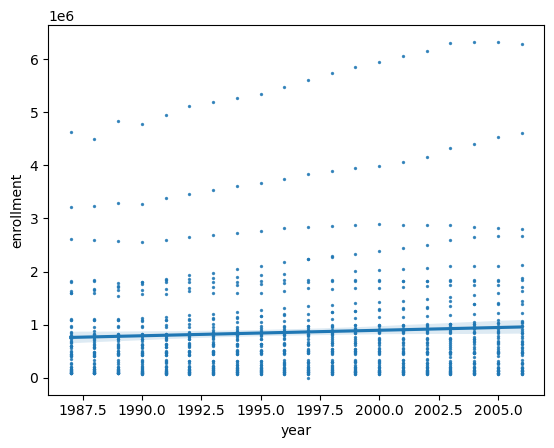

In [38]:
sns.regplot(x = non_county["year"], y = non_county["enrollment"], scatter_kws = {"s":2})

### Multiple linear regression

In [39]:
pd.get_dummies(data = non_county["division"])

,Division 1,Division 2,Division 3,Division 4,Division 5,Division 6,Division 7,Division 8,Division 9
1,0,0,0,0,0,1,0,0,0
69,0,0,0,0,0,0,0,0,1
99,0,0,0,0,0,0,0,1,0
115,0,0,0,0,0,0,1,0,0
191,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
31650,0,0,0,0,1,0,0,0,0
31787,0,0,0,0,0,0,0,0,1
31827,0,0,0,0,1,0,0,0,0
31883,0,0,1,0,0,0,0,0,0


In [40]:
non_county[["dummy_div_1", "dummy_div_2", "dummy_div_3", "dummy_div_4", "dummy_div_5", "dummy_div_6", "dummy_div_7", "dummy_div_8"]] = pd.get_dummies(data = non_county["division"])[["Division 1", "Division 2", "Division 3", "Division 4", "Division 5", "Division 6", "Division 7", "Division 8"]]

mlr_fit = linear_model.LinearRegression()
mlr_fit.fit(non_county[["year", "dummy_div_1", "dummy_div_2", "dummy_div_3", "dummy_div_4", "dummy_div_5", "dummy_div_6", "dummy_div_7", "dummy_div_8"]], non_county["enrollment"].values)
print(mlr_fit.intercept_, mlr_fit.coef_)

-19219174.61294101 [   10355.98042221 -1107855.75         437619.58333333     2187.28
 -1005594.80714286  -673870.105       -766572.2875       -48516.425
 -1079067.3875    ]


In [41]:
non_county.year.unique()

array([1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995.,
       1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
       2005., 2006.])

## Cross-validation

Creating a function to take an input of a dataframe, defined prediction and response variables, and the last year to be considered. This function outputs the mean square error and mean error of the prediction for the next year

In [42]:
def mse_SLR(df, predictors, response, last_year):
    subset_train=df.loc[df['year'] <=(last_year)]
    subset_test=df.loc[df['year']==last_year+1]
    reg=linear_model.LinearRegression()
    reg.fit(X=subset_train[predictors].values.reshape(-1,1), y=subset_train[response].values)
    preds = reg.predict(subset_test[predictors].values.reshape(-1,1))
    MSE = mean_squared_error(subset_test[response],preds)
    sqrt=math.sqrt(MSE)
    print('MSE =',round(MSE,2))
    print('mean error= ',round(sqrt,2))

In [43]:
mse_SLR(non_county, predictors='year', response='enrollment', last_year=1989)

MSE = 726904969770.15
mean error=  852587.22


In [44]:
mse_SLR(non_county, predictors='year', response='enrollment', last_year=1990)

MSE = 772730062771.74
mean error=  879050.66


In [45]:
mse_SLR(non_county, predictors='year', response='enrollment', last_year=1991)

MSE = 818824706572.34
mean error=  904889.33


In [46]:
#test_3 = non_county.loc[non_county["year"] < min(non_county["year"] + 3)]
#test_3 = non_county.loc[non_county["year"][:,1990]
#test_3.year.unique()


In [47]:
X_train, X_test, y_train, y_test = train_test_split(non_county[["year", "dummy_div_1", "dummy_div_2", "dummy_div_3", "dummy_div_4", "dummy_div_5", "dummy_div_6", "dummy_div_7", "dummy_div_8"]], non_county["enrollment"], test_size = 0.20, random_state = 42)

In [48]:
non_county.year.values

array([1987., 1987., 1987., ..., 2006., 2006., 2006.])